# Teaching a Robot to Move

First, we have a neural network watch a teacher. The robot starts at the end of a hallway, and approaches a target location 1 meter from the end of the hall.

In [1]:
from conx import *
from jyro.simulator import *
import math
import time

Using Theano backend.
conx, version 3.5.2


In [2]:
def make_world(physics):
    physics.addBox(0, 0, 8, 2, fill="backgroundgreen", wallcolor="gray")
    
def make_robot():
    robot = Pioneer("Pioneer", 7.5, 1, math.pi/2) #parameters are x, y, heading (in radians)
    robot.addDevice(PioneerFrontSonar(6))
    robot.addDevice(Camera())
    return robot

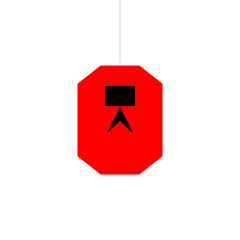

In [3]:
robot = make_robot()
robot

In [52]:
def collect_data(simulator):
    data = []
    simulator.reset() # put robot back to where it is defined
    while True:
        scaled_dist = simulator.robot["sonar"].getData()[0]/6.0
        if scaled_dist <= 0.66:
            power = 0
        elif scaled_dist <= 0.77:
            power = 0.25
        elif scaled_dist <= 0.88:
            power = 0.50
        else:
            power = 1.0
        robot.move(power, 0)
        data.append([scaled_dist, [power]])
        simulator.step()
        time.sleep(.1) # don't overwhelm the network
        if power == 0:
            ## even out the training data a bit:
            for i in range(len(data)//2):
                data.append([scaled_dist, [power]])
            break
    return data

In [53]:
sim = VSimulator(robot, make_world, size=(700, 180))

VBox(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Update GUI'), Checkbox(value=False, description='Trace Path'), Text(value='0.0 seconds', description='Time:'))), HBox(children=(VBox(children=(HBox(children=(FloatSlider(value=0.0, layout=Layout(height='180px', padding='0px 0px 0px 0px', width='15px'), orientation='vertical', readout=False), HTML(value='<svg baseProfile="full" height="180" version="1.1" width="700" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="#eef3dd" height="175.0" stroke="#bebebe" stroke-width="1" width="700.0" x="0.0" y="0.0" /><line fill="#800080" stroke="#d3d3d3" stroke-width="1" x1="656.25" x2="131.25" y1="87.5" y2="87.49999999999996" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="656.25" x2="605.7318512251488" y1="87.5" y2="175.0" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="656.25" x2="605.7318512251488" y1="87.5" y2="0.0" /><polygon fill="red" points="636.5625,94.5 643.125,102.8125 669.375,102.8125 675.9375,94.5 675.9375,80.5 669.375,72.1875 643.125,72.1875 636.5625,80.5" stroke="red" stroke-width="1" /><polygon points="-4.375,-4.375 0,0 4.375,-4.375 0,4.375" stroke="black" stroke-width="1" transform="translate(656.25,87.5) rotate(90.0)" /><polygon fill="black" points="644.0,82.25 651.0,82.25 651.0,92.75 644.0,92.75" stroke="black" stroke-width="1" /></svg>'))), FloatSlider(value=0.0, layout=Layout(height='15px', padding='0px 0px 0px 10px', width='720px'), readout=False)), layout=Layout(height='240px')), VBox(children=(HTML(value='<img style="image-rendering: pixelated;" src="data:image/gif;base64,R0lGODdhPAAoAIcAAO7z3a3Y5qioqKenp6ampqWlpaSkpKOjo6KioqGhoaCgoJ6enp2dnZubm5mZmZeXl5SUlJGRkY6OjomJiYSEhH5+fnV1dWpqalxcXEZGRi8vLy4uLgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwAAAAAPAAoAEAI/wADCBxIsKDBgwgTKlzIsKHDhwIGDCBQoICBAwgSKFjAoIGDBxAiSJhAoYKFAChTqlRpoQKFCRIiQHjgoAGDBQoSIDhgoEABAgMGCBAwYACBAgUMHECQQMECBg0cPIAQQcIEChUAaN3KtSuAChQmSIgA4YGDBgwWKEiA4ICBAgUIDBggAIDdu3jz6t3Lt6/fvAECCx5MuLDhw4gTExYwYACBAgUCSJ5MubLly5gzTy5QgMCAAQIEDBhAoEABAwcQJFCwgEEDBw8gRJAwgUIFCxcwZNiwQYNvDRs2ZMBwwUIFChMkRIDwwEEDBgsUJEBwwECBAgQGDBAAoLv37+DDi/8fT768+fPo06sPwL69+/fw48ufT7++/fv48+vfz3++AIADBhAoUMDAAQQJFCxg0MDBAwgRJASgWNHiRYwBJESA8MBBAwYLFCRAcMBAgQIEBgwQIGDAAAIFChg4gCCBggUMGjh4ACGChAkUKli4gCHAUaRJMVywUIHCBAkRIDxw0IDBAgUJEBwwUKAAgQEDBAgYMIBAgQIGDiBIoGABgwYOHkCIIGEChQoWLmAA0NfvXwwXLFSgMEFCBAgPHDRgsEBBAgQHDBQoQGDAAAECBgwgUKCAgQMIEihYwKCBgwcQAKxm3dr1a9cQHjhowGCBggQIDhgoUIDAgAECAAwnXtz/+HHkyZUvZ97c+XPo0aVPVx7A+nXs2bVv597d+3fw4cWPJ1/e/Hn06dWvZ9/efXcBAwYQKFDAwAEECRQsYNDAAcAAAgcSLGjwoEAHDRgsUJAAwQEDBQoQGDBAgIABAwgUKGDgAIIEChYwaODgAYQIEiZQCODyJcyYLylMkBABwgMHDRgsUJAAwQEDBQoQGDBAgIABAwgUKGDgAIIEChYwaODgAYQIEiZQqGDhQoCwYseGvWChAoUJEiJAeOCgAYMFChIgOGCgQAECAwYIEDBgAIECBQwcQJBAwQIGDRw8gBBBwgQKFSxcwJBhwwYNmjVs2JABwwULFShMkBABwgMH/w0YLFCQAMEBAwUKEBgwQICAAQMIFChg4ACCBAoWMGjg4AGECBImUKhg4QKGDACmU5+eAcMFCxUoTJAQAcIDBw0YLFCQAMEBAwUKEBgwQICAAQMIFChg4ACCBAoWMGjgAOADCBEkTKBQwcIFAAsZNlx4wUIFChMkRIDwwEEDBgsUJEBwwECBAgQGDBAgYMAAAgUKGDiAIIGCBQwaOHgAIYK

In [54]:
data = collect_data(sim)

In [55]:
len(data)

93

In [56]:
train = ["Training Data", [pair[1][0] for pair in data]]

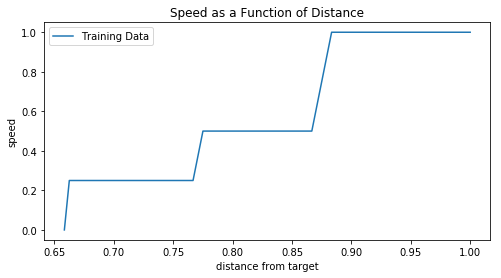

In [57]:
plot(train, 
     title="Speed as a Function of Distance",
     xlabel="distance from target",
     ylabel="speed",
     xs=[pair[0] for pair in data])

In [82]:
net = Network("Go To Target")
net.add(Layer("input", 1))
net.add(Layer("hidden", 10, activation="sigmoid"))
net.add(Layer("output", 1, activation = "linear"))
net.connect()
net.compile(loss="mae", optimizer="adam")
net.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
hidden (Dense)               (None, 10)                20        
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [83]:
net.dataset.load(data)
net.dataset.summary()

Input Summary:
   count  : 93 (93 for training, 0 for testing)
   shape  : [()]
   range  : (0.65833336, 1.0)
Target Summary:
   count  : 93 (93 for training, 0 for testing)
   shape  : [(1,)]
   range  : (0.0, 1.0)


In [84]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=1.0, continuous_update=False, description='Zoom', max=3.0, min=0.5), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=2.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=2, options=('input', 'hidden', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPEBAY8AAM8AAAEB8q8AAAAAbwAAsAAAkAAA0PTo8vr3+wAAV0dH/7e3//9WVv/W1hYW/zQ0/2dn/4aG/6Sk/9nZ//8XF/82Nv9oaP+Xl/+1tSQk/1lZ/3h4/5SU/8nJ//8mJv9ERP95ef+Hh/+mpv/ExH8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
net.reset()
net.delete()

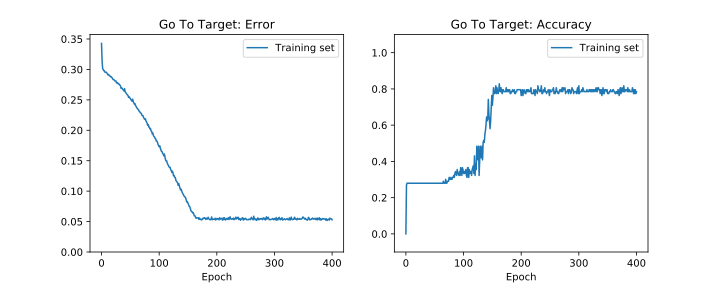

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#  400 |   0.05284 |   0.78495 
Saving network... Saved!


In [86]:
if net.saved():
    net.load()
    net.plot_loss_acc()
else:
    net.train(400, accuracy=1.0, tolerance=0.1, batch_size=1, save=True, plot=True)

In [87]:
test = ["Network", [net.propagate(pair[0], visualize=False)[0] for pair in data]]

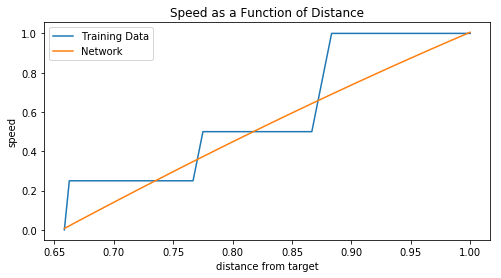

In [88]:
plot([train, test], 
     title="Speed as a Function of Distance",
     xlabel="distance from target",
     ylabel="speed",
     xs=[pair[0] for pair in data])

# Network-Controlled Robot

In [95]:
outputs = []

def net_brain(robot):
    scaled_distance = robot["sonar"].getData()[0]/6
    output = net.propagate([scaled_distance], visualize=False)[0]
    robot.move(output, 0)
    outputs.append([scaled_distance, output])
        
robot.brain = net_brain

In [96]:
sim.widget

VBox(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Update GUI'), Checkbox(value=False, description='Trace Path'), Text(value='24.10 seconds', description='Time:'))), HBox(children=(VBox(children=(HBox(children=(FloatSlider(value=50.0, layout=Layout(height='180px', padding='0px 0px 0px 0px', width='15px'), orientation='vertical', readout=False), HTML(value='<svg baseProfile="full" height="180" version="1.1" width="700" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="#eef3dd" height="175.0" stroke="#bebebe" stroke-width="1" width="700.0" x="0.0" y="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="343.65673578088155" x2="0.0" y1="87.5" y2="87.5" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="343.65673578088155" x2="293.13859039238343" y1="87.5" y2="175.0" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="343.65673578088155" x2="293.13859039238343" y1="87.5" y2="0.0" /><polygon fill="red" points="323.96923578088155,94.5 330.53173578088155,102.8125 356.78173578088155,102.8125 363.3442357808815,94.5 363.3442357808815,80.5 356.78173578088155,72.1875 330.53173578088155,72.1875 323.96923578088155,80.5" stroke="red" stroke-width="1" /><polygon points="-4.375,-4.375 0,0 4.375,-4.375 0,4.375" stroke="black" stroke-width="1" transform="translate(343.65673578088155,87.5) rotate(90.0)" /><polygon fill="black" points="331.4067357808815,82.25 338.40673578088155,82.25 338.40673578088155,92.75 331.4067357808815,92.75" stroke="black" stroke-width="1" /></svg>'))), FloatSlider(value=49.09381939726879, layout=Layout(height='15px', padding='0px 0px 0px 10px', width='720px'), readout=False)), layout=Layout(height='240px')), VBox(children=(HTML(value='<img style="image-rendering: pixelated;" src="data:image/gif;base64,R0lGODdhPAAoAIcAAO7z3a3Y5qioqKenp6ampqWlpaSkpKOjo6KioqGhoaCgoJ6enp2dnZubm5mZmZeXl5SUlJGRkY6OjomJiYSEhH5+fnV1dXNzc3JycnFxcQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwAAAAAPAAoAEAI/wADCBxIsKDBgwgTKlzIsKHDhwIGDCBQoICBAwgSKFjAoIGDBxAiSJhAoYKFDBkwYLjAsiUGDBkyWKhAYYKECBAeOGjAYIGCBAgOGChQgMCAAQIEDBhAoEABAwcQJFCwgEEDBw8gRJAwgUIFAGDDih0LoAKFCRIiQHjgoAGDBQoSIDhgoEABAgMGCADAt6/fv4ADCx5M+G+Aw4gTK17MuLHjx4oFDBhAoECBAJgza97MubPnz5kLFCAwYIAAAQMGEChQwMABBAkULGDQwMEDCBEkTKBQwUKGDBgwXBhOHAOGDBksVKAwQUIECA8cNGCwQEECBAcMFChAYMAAAQDCi/8fT768+fPo06tfz769+wDw48ufT7++/fv48+vfz7+/f4ABBA4kWNDgQYQIBQwYQKBAAQMHECRQsIBBAwcPIESQEMDjR5AhRQaQEAHCAwcNGCxQkADBAQMFChAYMECAgAEDCBQoYOAAggQKFjBo4OABhAgSJlCoYCFDBgwYLkyligFDhgwWKlCYICEChAcOGjBYoCABggMGChQgMGCAAAEDBhAoUMDAAQQJFCxg0MDBAwgRJEygUMFChgwYMFxg3BgDhgwZLFSgMEFCBAgPHDRgsEBBAgQHDBQoQGDAAAECBgwgUKCAgQMIEihYwKCBgwcQAOzm3dv3b98QHjhowGD/gYIECA4YKFCAwIABAgBMp17d+nXs2bVv597d+3fw4cWP1x7A/Hn06dWvZ9/e/Xv48eXPp1/f/n38+fXv59/fP8AAAgcOFDBgAIECBQwcQJBAwQIGDRwEqGjxIsaMGis6aMBggYIECA4YKFCAwIABAgQMGECgQAEDBxAkULCAQQMHDyBEkDCBQoCgQocSFUphgoQIEB44aMBggYIECA4YKFCAwIABAgQMGECgQAEDBxAkULCAQQMHDyBEkDCBQgULGTJgwHDhLl4MGDJksFCBwgQJESA8cNCAwQIFCRAcMFCgAIEBAwQIGDCAQIECBg4gSKBgAYMGDh5AiCBhAoUK/xYyZMCA4QLs2BgwZMhgoQKFCRIiQHjg

In [97]:
trained_range = ["Net in Trained Range", [pair for pair in outputs if pair[0] > .66]]

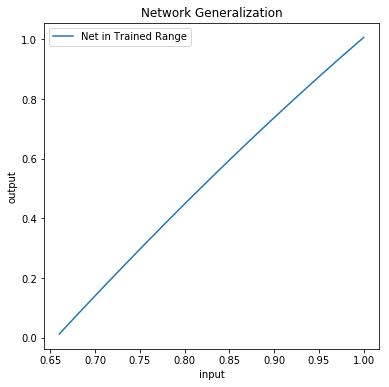

In [102]:
scatter(trained_range,
       title="Network Generalization", xlabel="input", ylabel="output")

In [100]:
untrained_range = ["Net out of Trained Range", [pair for pair in outputs if pair[0] <= .66]]

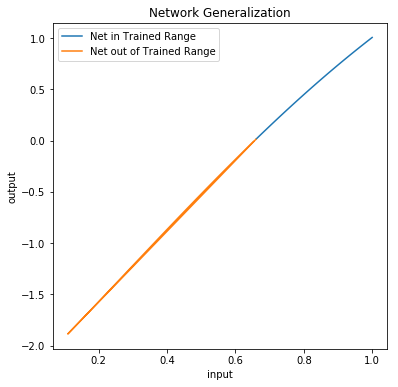

In [103]:
scatter([trained_range, untrained_range],
        title="Network Generalization", xlabel="input", ylabel="output")